# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **23.10.2023**

Мягкий дедлайн: **08.11.23 23:59**

Жесткий дедлайн: **12.11.23 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) =  \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

$$
\nabla_w Q(w) = \nabla_w[y^Ty - y^TXw - w^TX^Ty + w^TX^TXw] = 0 - X^Ty - X^Ty + (X^TX + X^TX)w = {2}X^T(Xw-y)
$$


In [805]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.



In [859]:
@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p
class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()
class BaseDescent:
    """
    A base class and templates for all functions
    """
    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass
    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass
    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        return np.dot((y - np.dot(x, self.w)).T, (y - np.dot(x, self.w))) / x.shape[0]

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return np.dot(x, self.w)


### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [860]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()
        update = - learning_rate * gradient 
        self.w += update

        return update

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        y_pred = self.predict(x)
        residual = y_pred - y 
        gradient = (2 / x.shape[0]) * (x.T @ residual) 
        return gradient

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [861]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch = np.random.randint(0, x.shape[0], self.batch_size)
        x_batch = x[batch]
        y_batch = y[batch]

        y_pred = self.predict(x_batch)
        
        residual = y_pred - y_batch
        gradient = (2 /  self.batch_size) * np.dot(np.transpose(x_batch), residual)
        return gradient


### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [862]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()

        self.h = self.alpha * self.h + learning_rate * gradient
        update_momentum = - self.h
        self.w += update_momentum
        return update_momentum


### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](https://github.com/esokolov/ml-course-hse/blob/master/2023-fall/homeworks-practice/homework-practice-03-gd/adam_meme.png?raw=1)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [863]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()
        self.iteration += 1 
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (gradient**2)
        m_hat = self.m / (1 - self.beta_1 ** (self.iteration))
        v_hat = self.v / (1 - self.beta_2 ** (self.iteration))
        update_adam = - learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)
        self.w += update_adam
        return update_adam


## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [864]:
from __future__ import annotations
from typing import List


class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []
        self.w_list: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        self.loss_history.append(self.calc_loss(x, y))

        for iteration in range(self.max_iter):
            y_pred = self.predict(x) 
            residual = y_pred - y 
            gradient = (2 / x.shape[0]) * (x.T @ residual)
            learning_rate =self.descent.lr()
            self.descent.w= self.descent.w - learning_rate * gradient
            self.w_list.append(self.descent.w)
            self.loss_history.append(self.calc_loss(x, y))

            if iteration > 0:
                if ((np.linalg.norm((self.w_list[-1] - self.w_list[-2]))**2) < self.tolerance) or (np.isnan(self.w_list[-1]).any()):              
                    break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)

## Задание 3. Проверка кода (0 баллов)

In [865]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [920]:
def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
         'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
         'momentum': MomentumDescent if not regularized else MomentumDescentReg,
         'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))

In [867]:
import numpy as np
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)


In [868]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic','momentum', 'adam']: #'stochastic','momentum', 'adam'
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [869]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'


Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/54610/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**: 95763425 prmuradkhanova@edu.hse.ru


* **StochasticDescent**: 95725733	



* **MomentumDescent**: 95725949


* **Adam**: 95733578




* **LinearRegression**: 95831590

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [818]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [870]:
data = pd.read_csv('https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2023-fall/homeworks-practice/homework-practice-03-gd/autos.csv')

Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

C:\Users\murad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


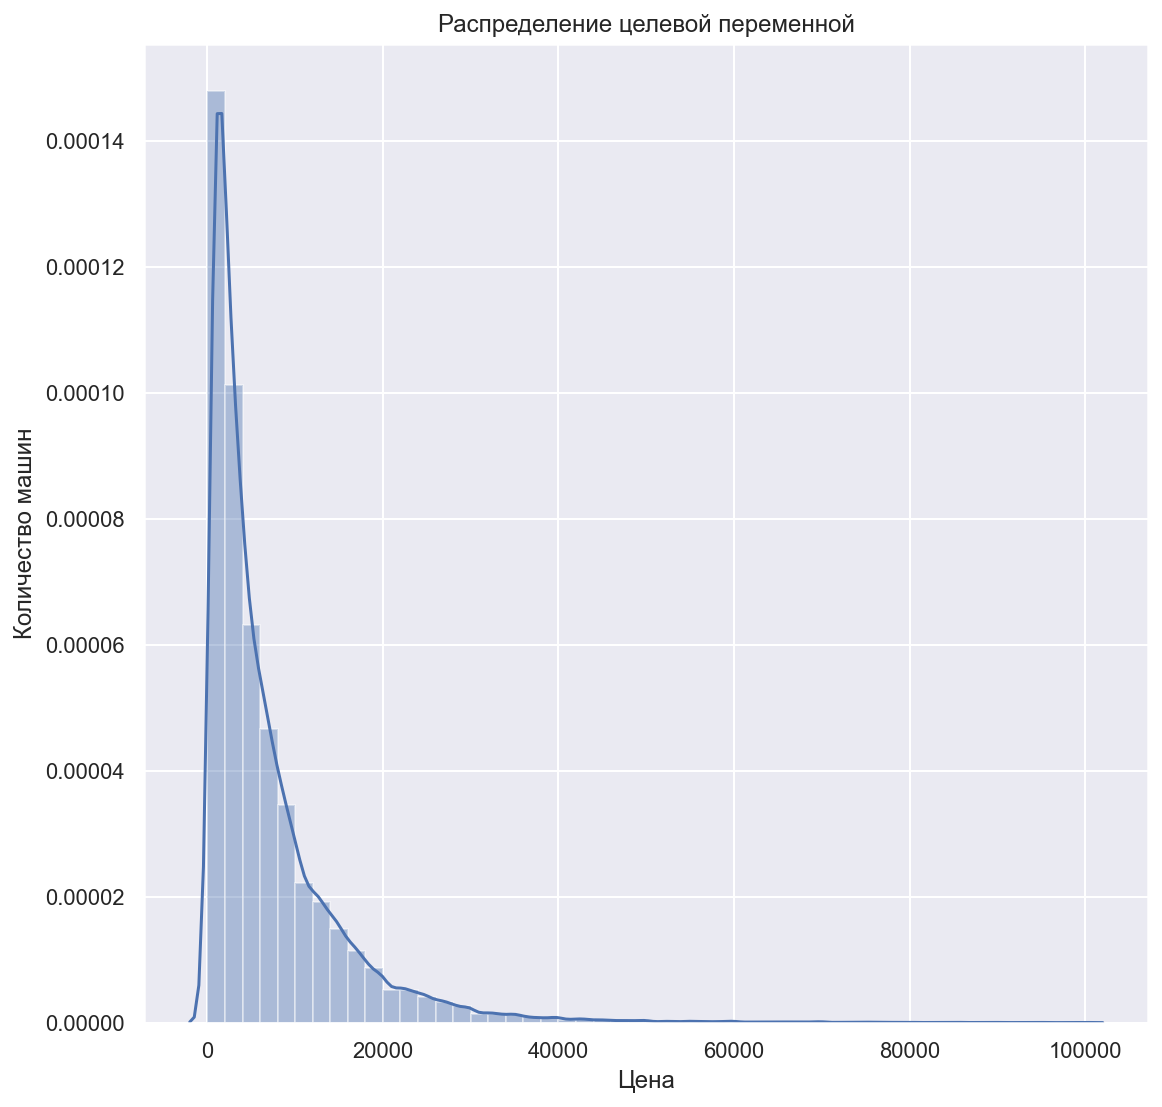

In [820]:
plt.figure(figsize=(9, 9)) #можно сгладить целевую переменную с помощью логарифмирования, тк есть выбросы
sns.distplot(data['price'])
plt.xlabel('Цена')
plt.ylabel('Количество машин')
plt.title('Распределение целевой переменной')
plt.show()

C:\Users\murad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


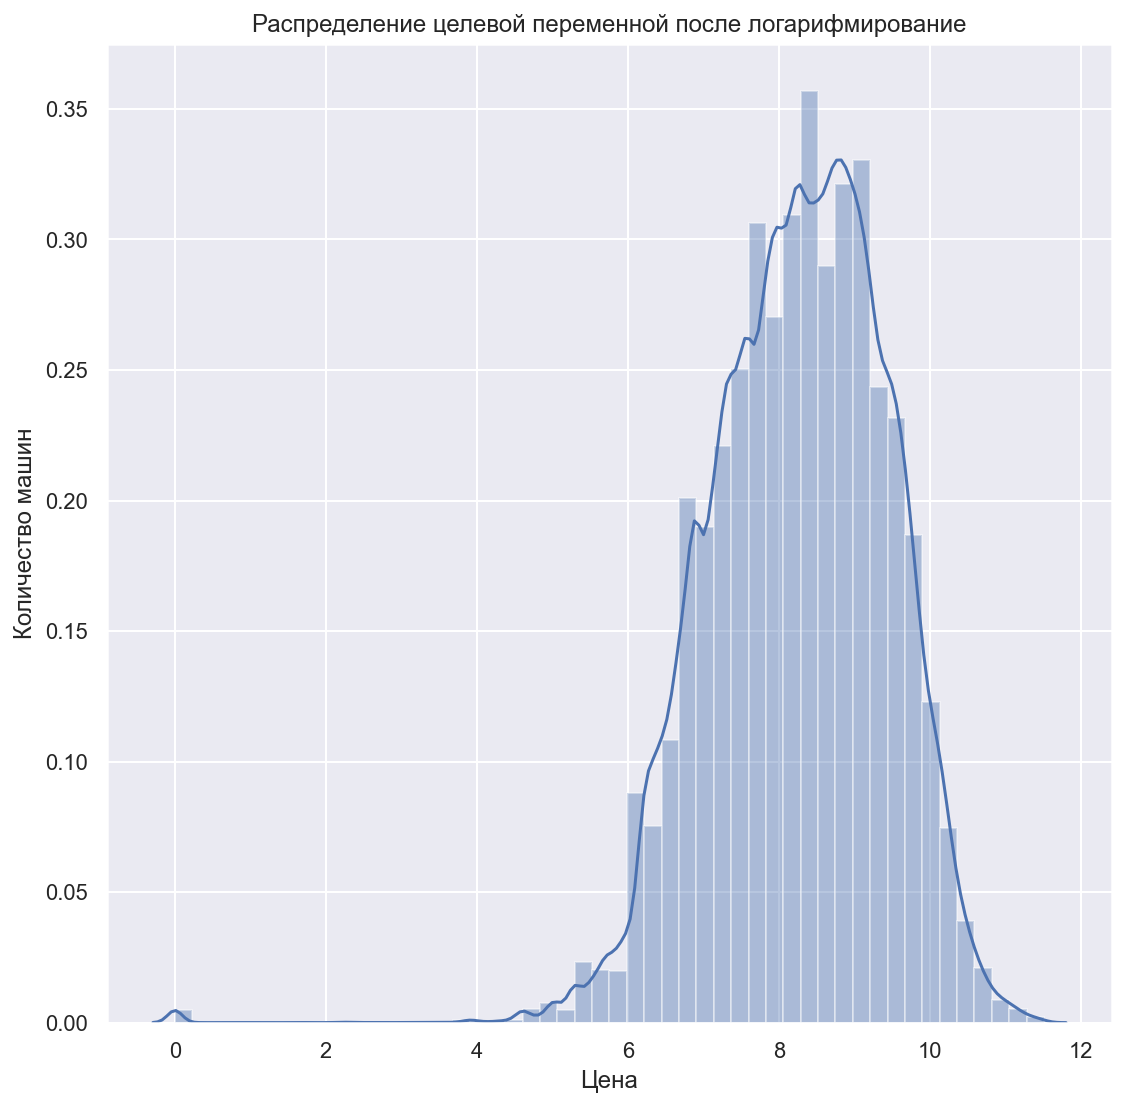

In [821]:
plt.figure(figsize=(9, 9))
sns.distplot(np.log(data['price']))
plt.xlabel('Цена')
plt.ylabel('Количество машин')
plt.title('Распределение целевой переменной после логарифмирование')
plt.show()

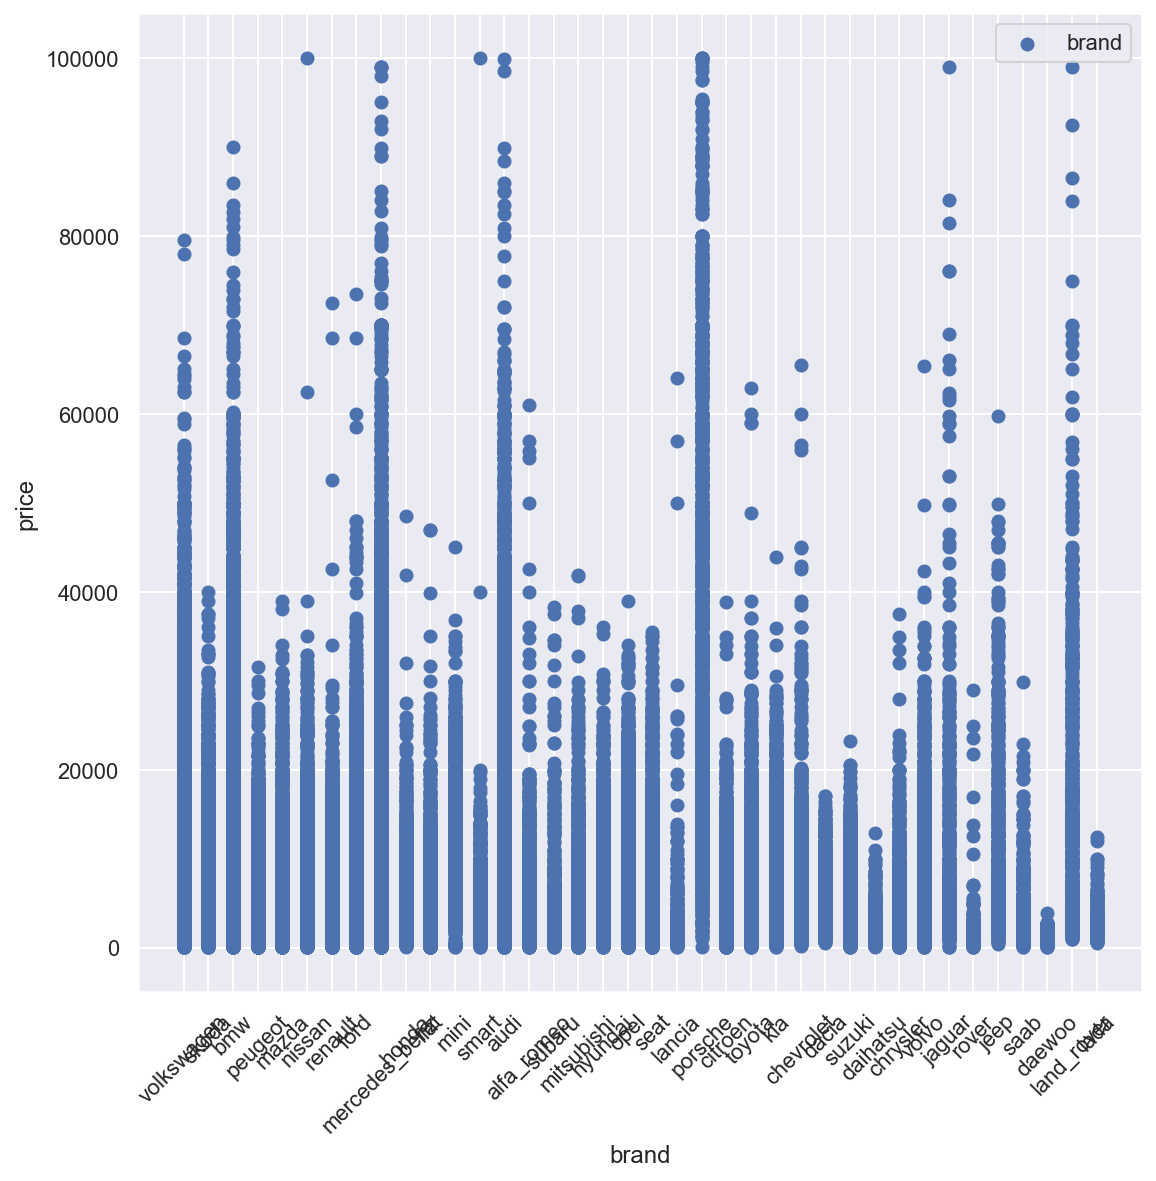

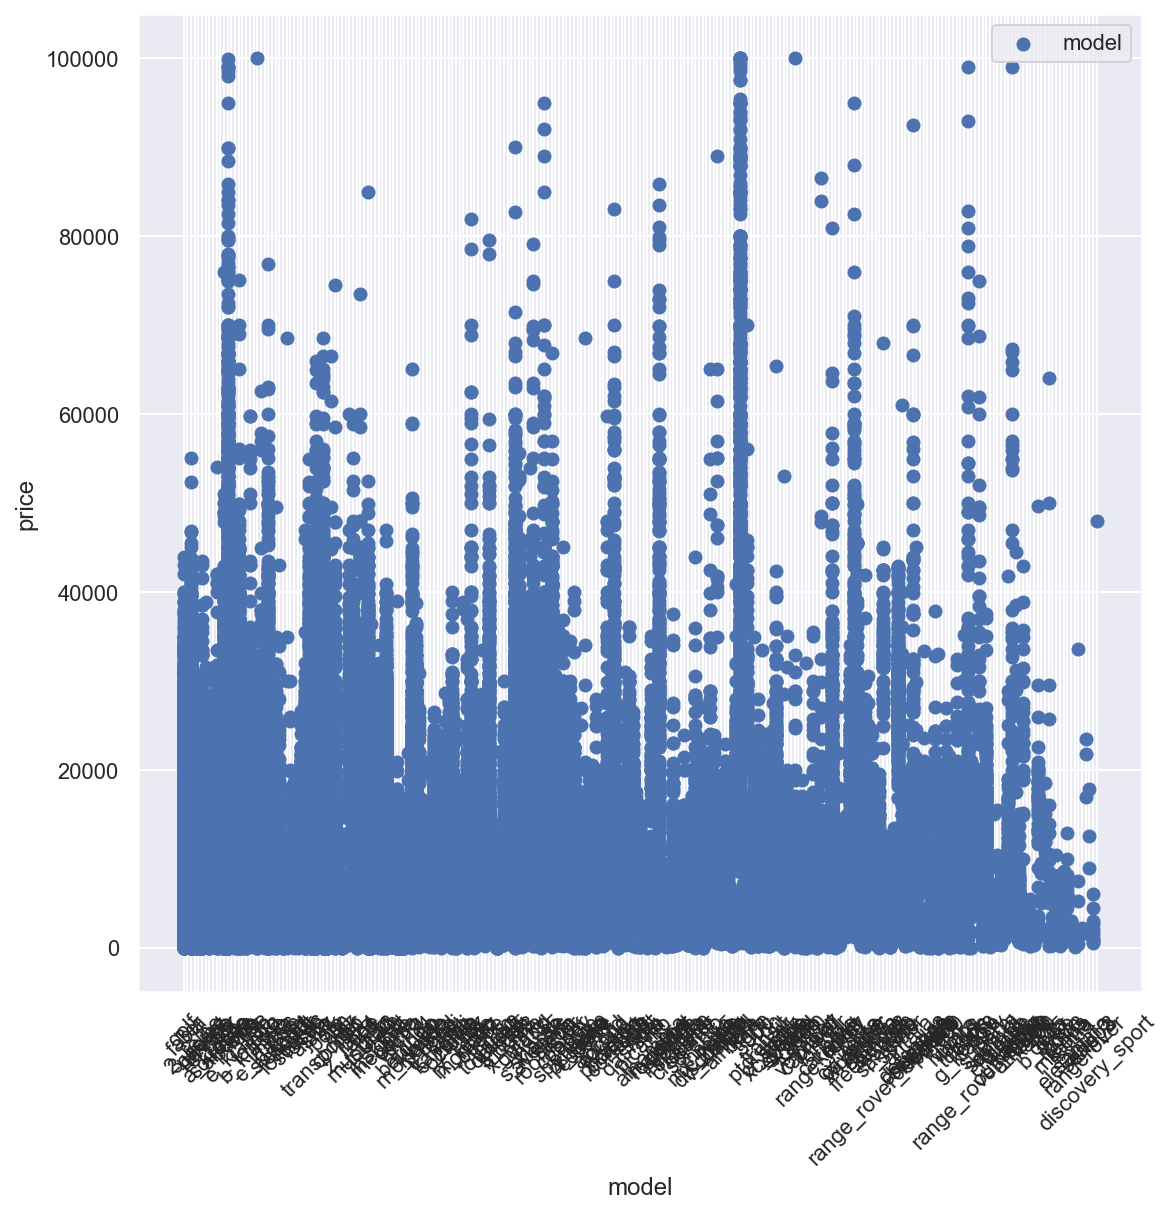

C:\Users\murad\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


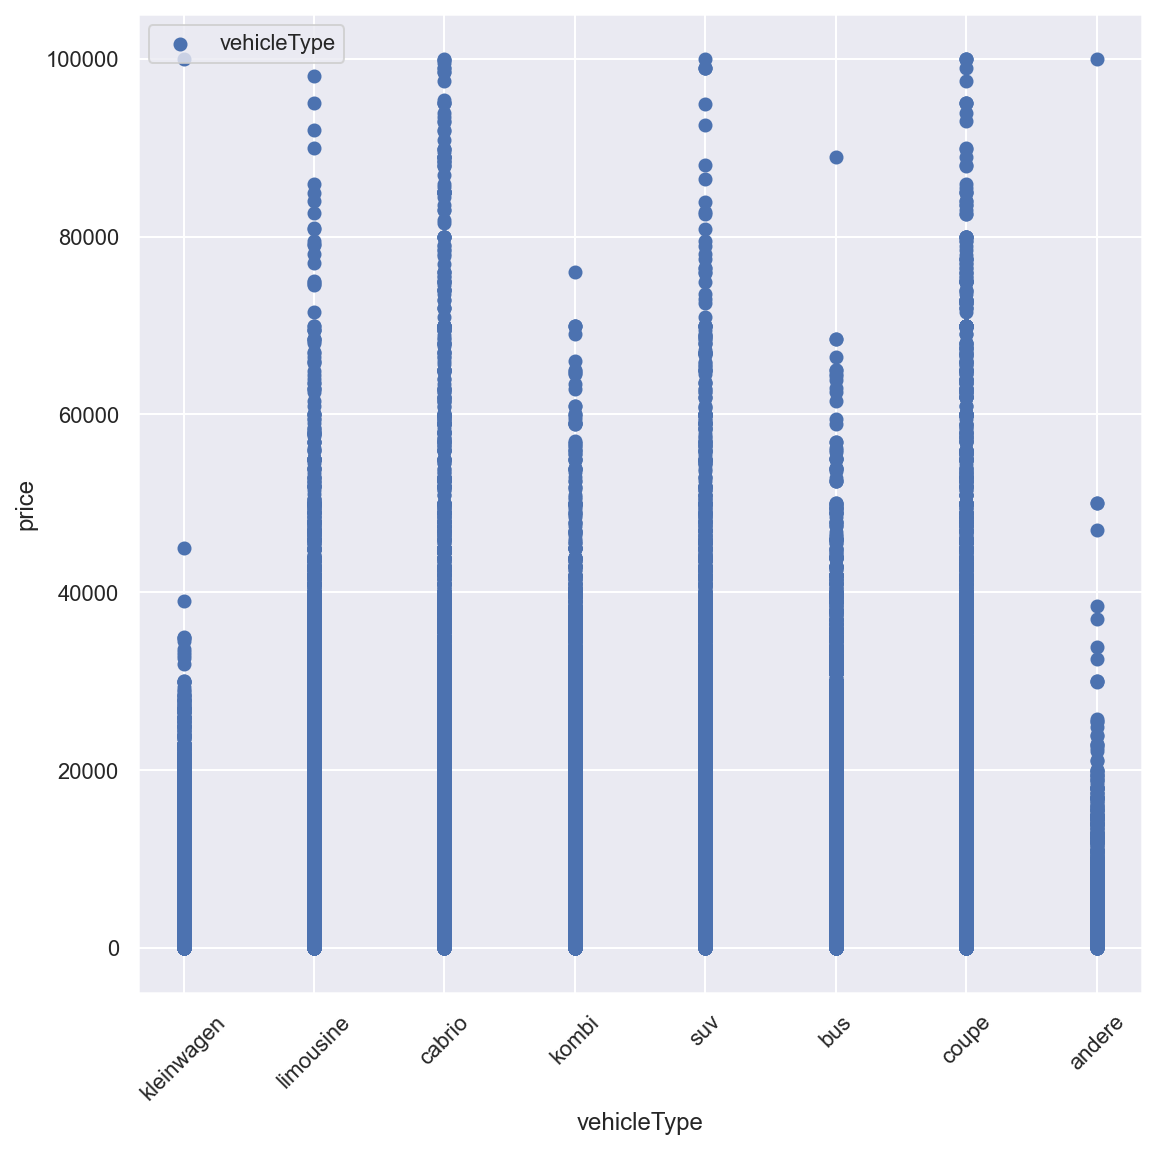

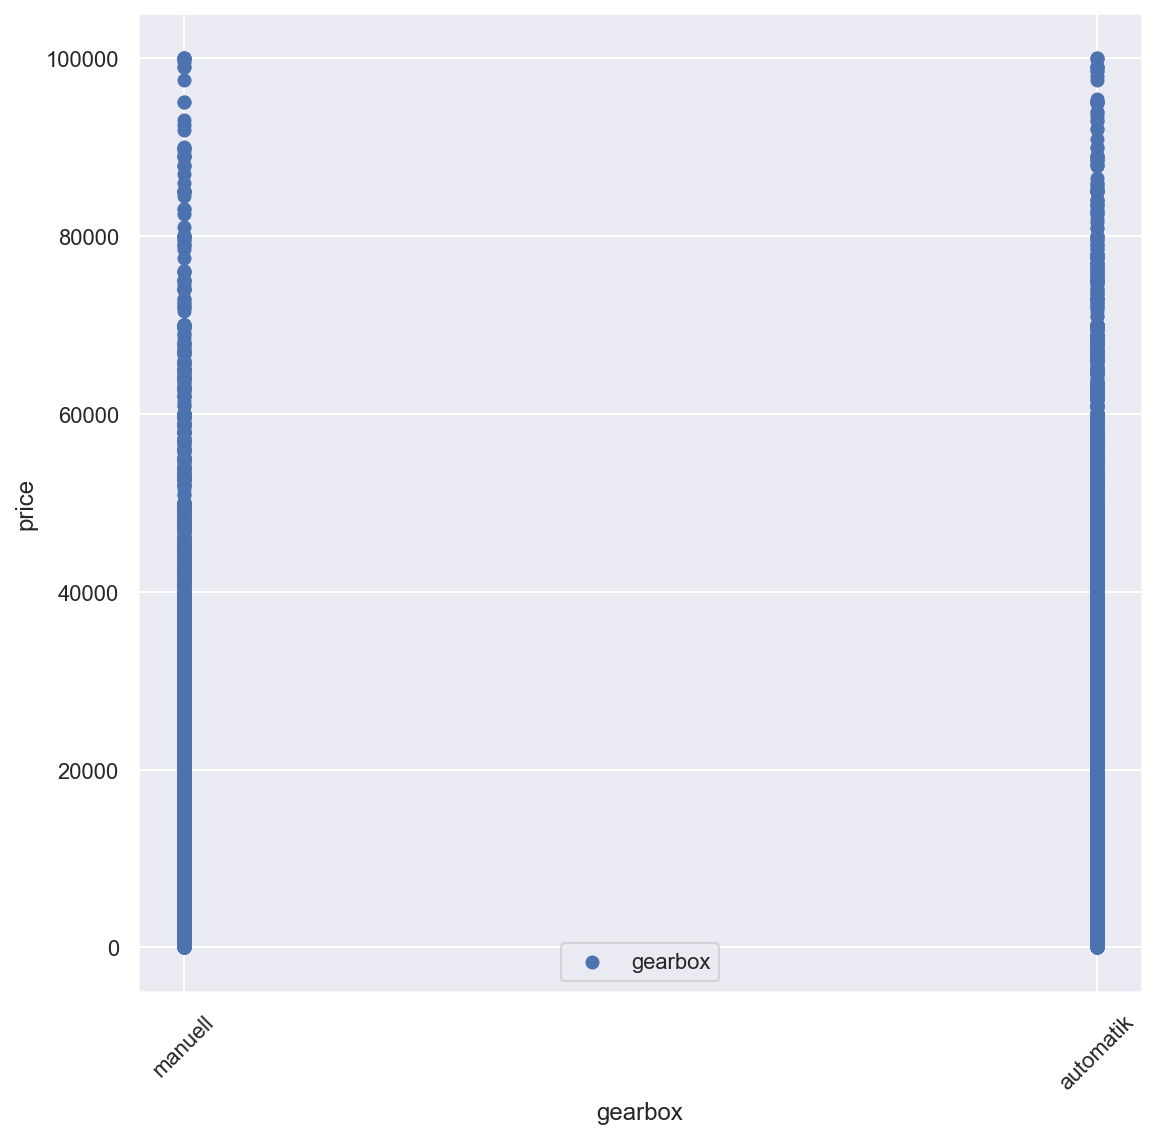

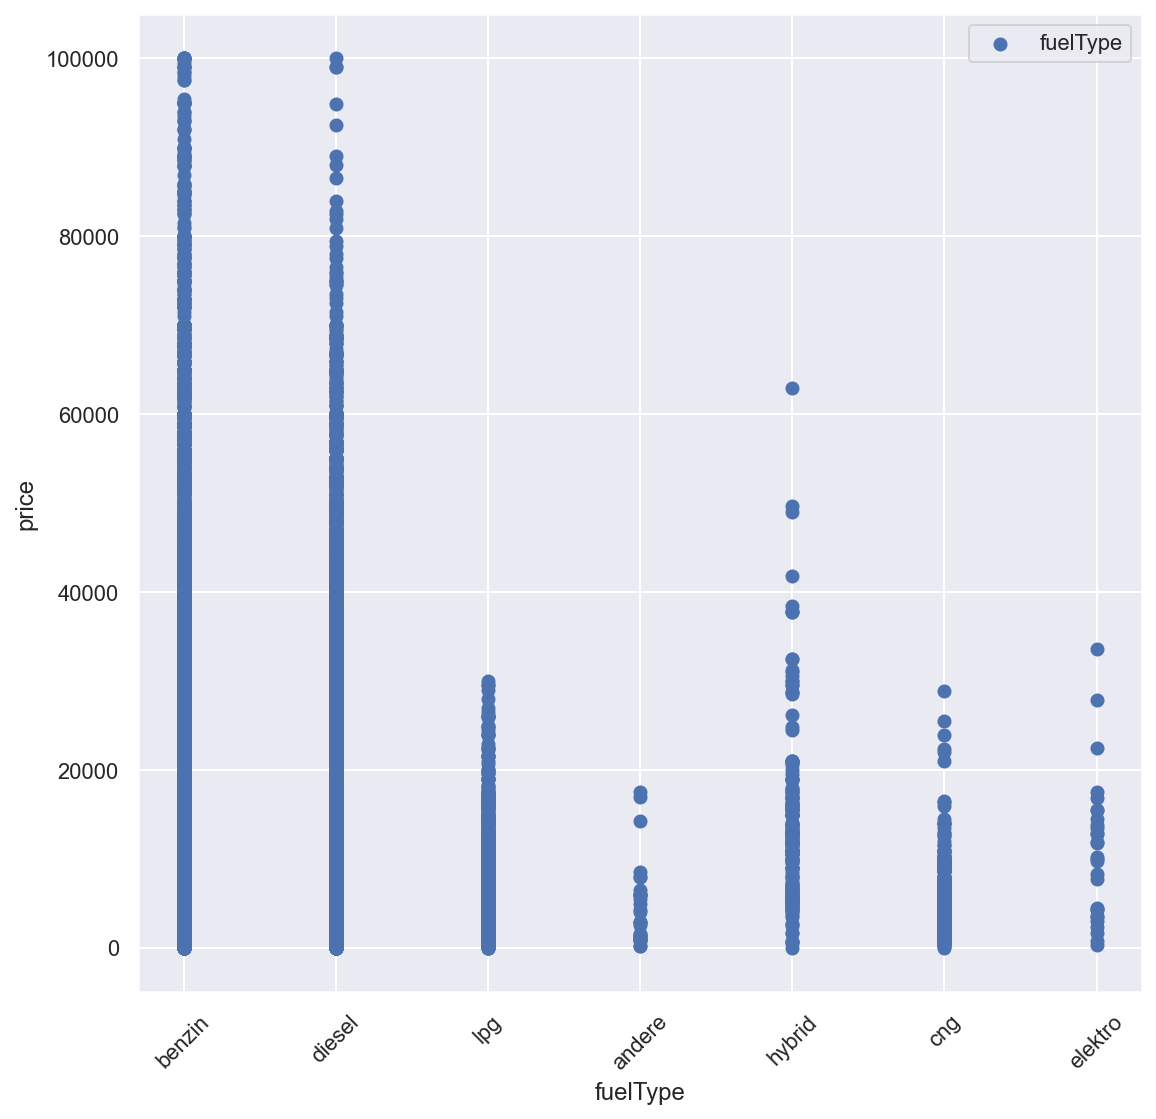

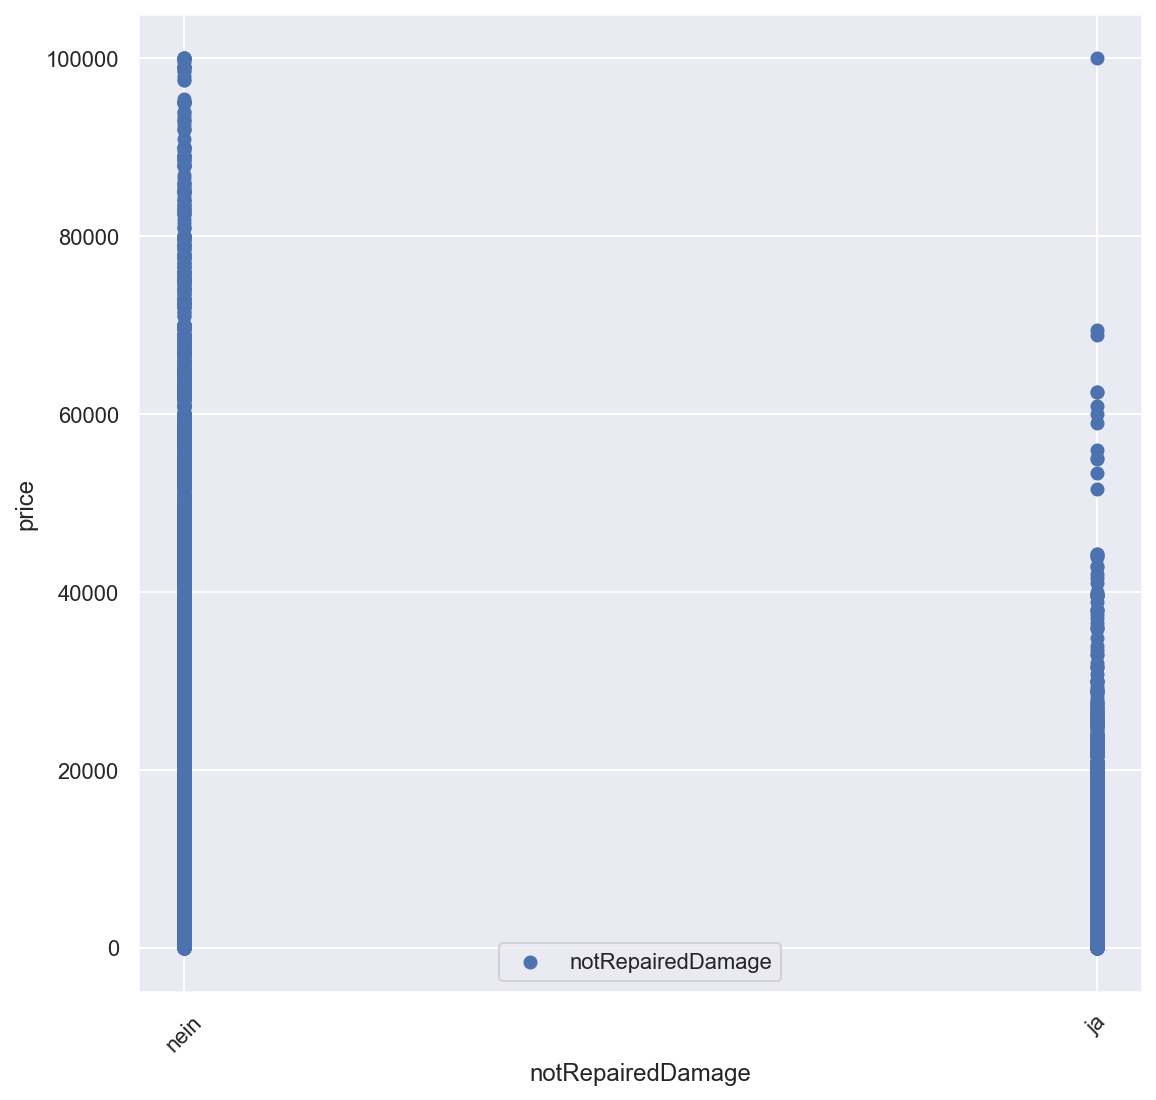

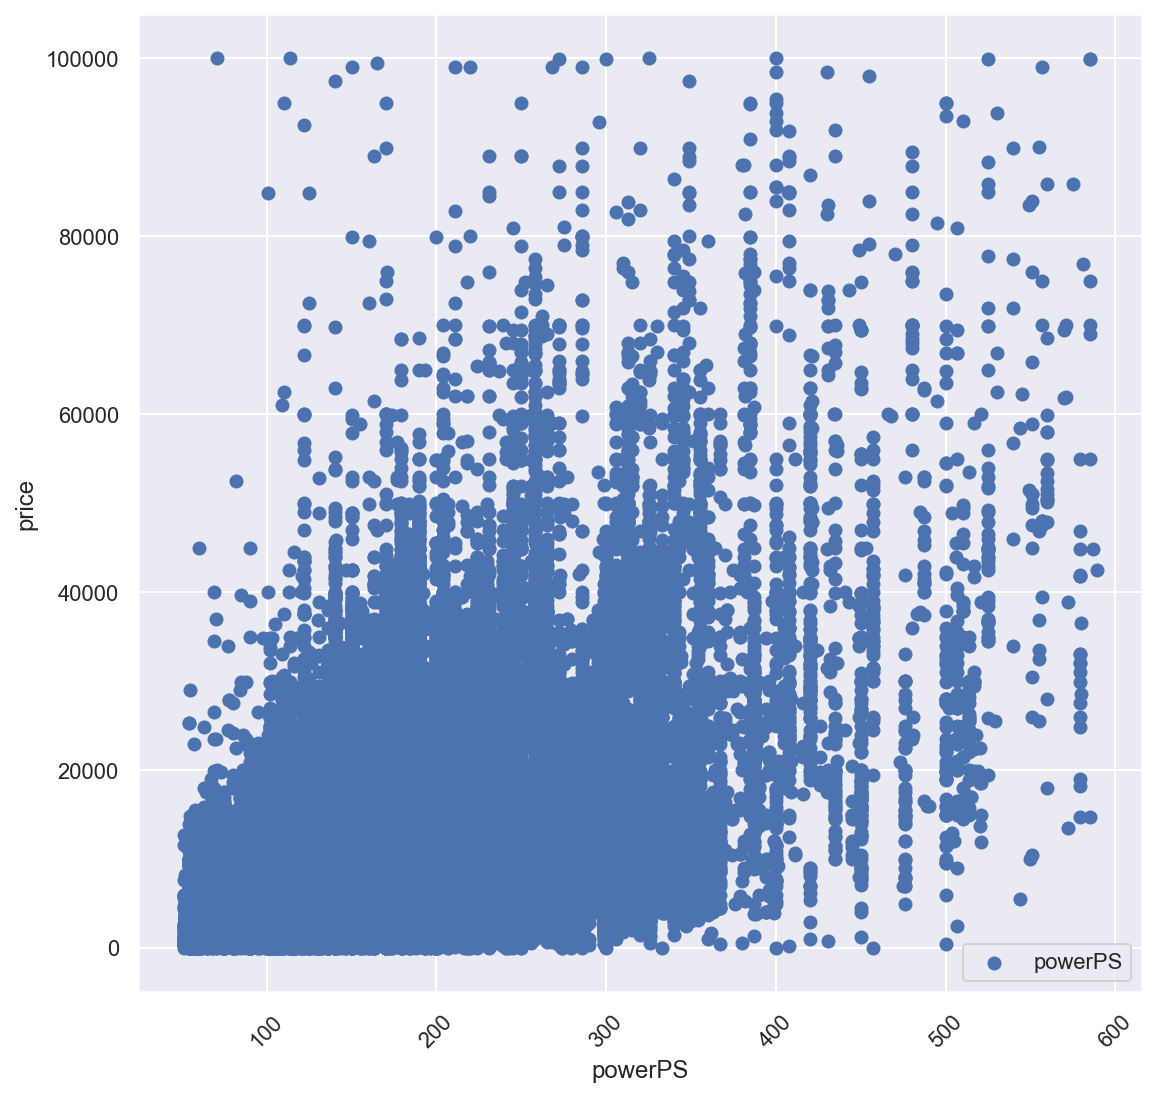

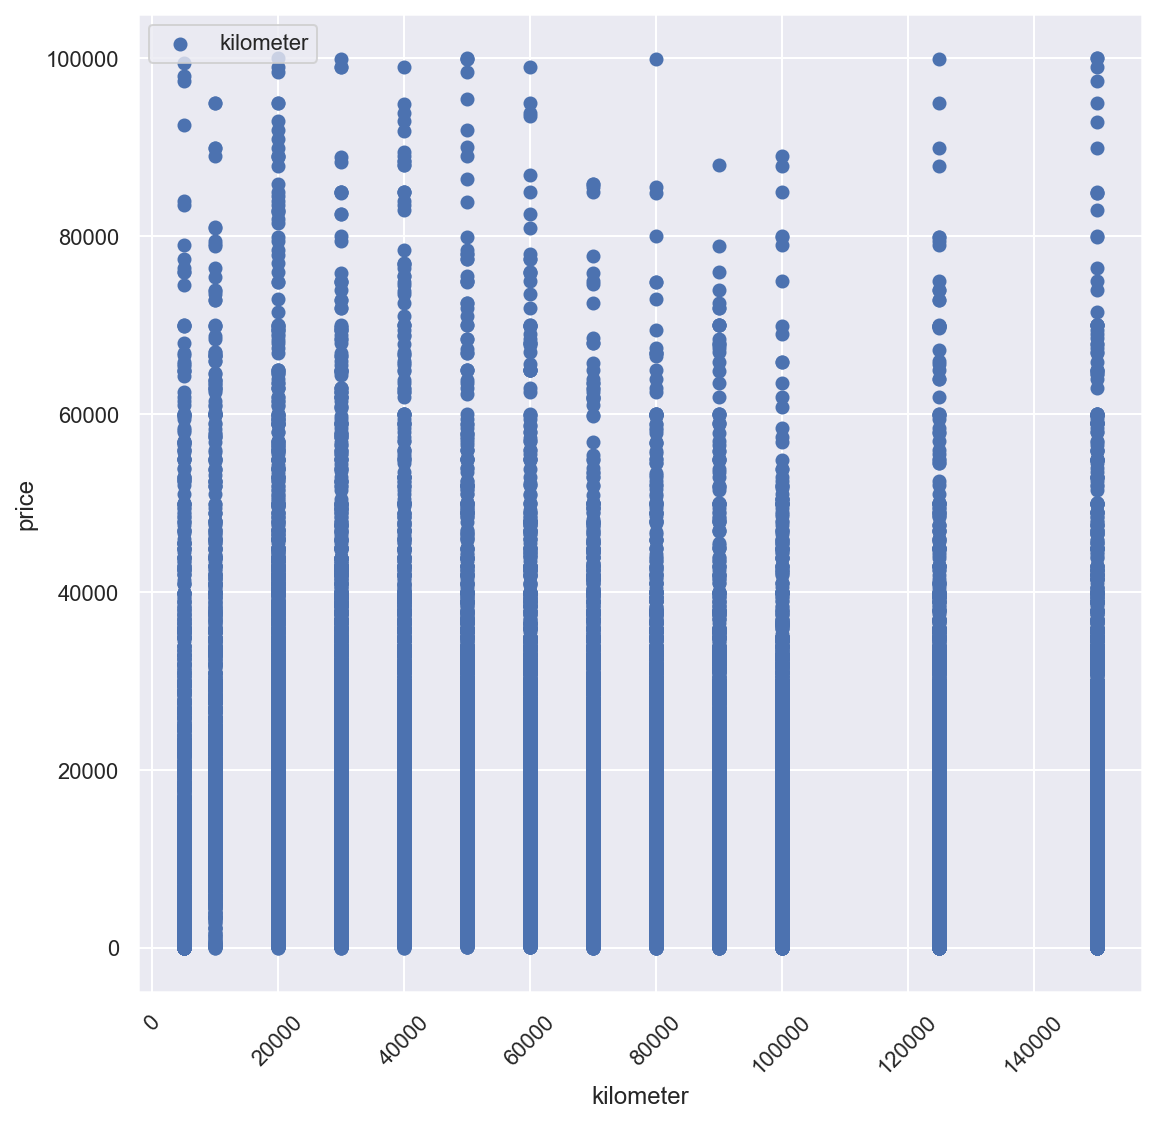

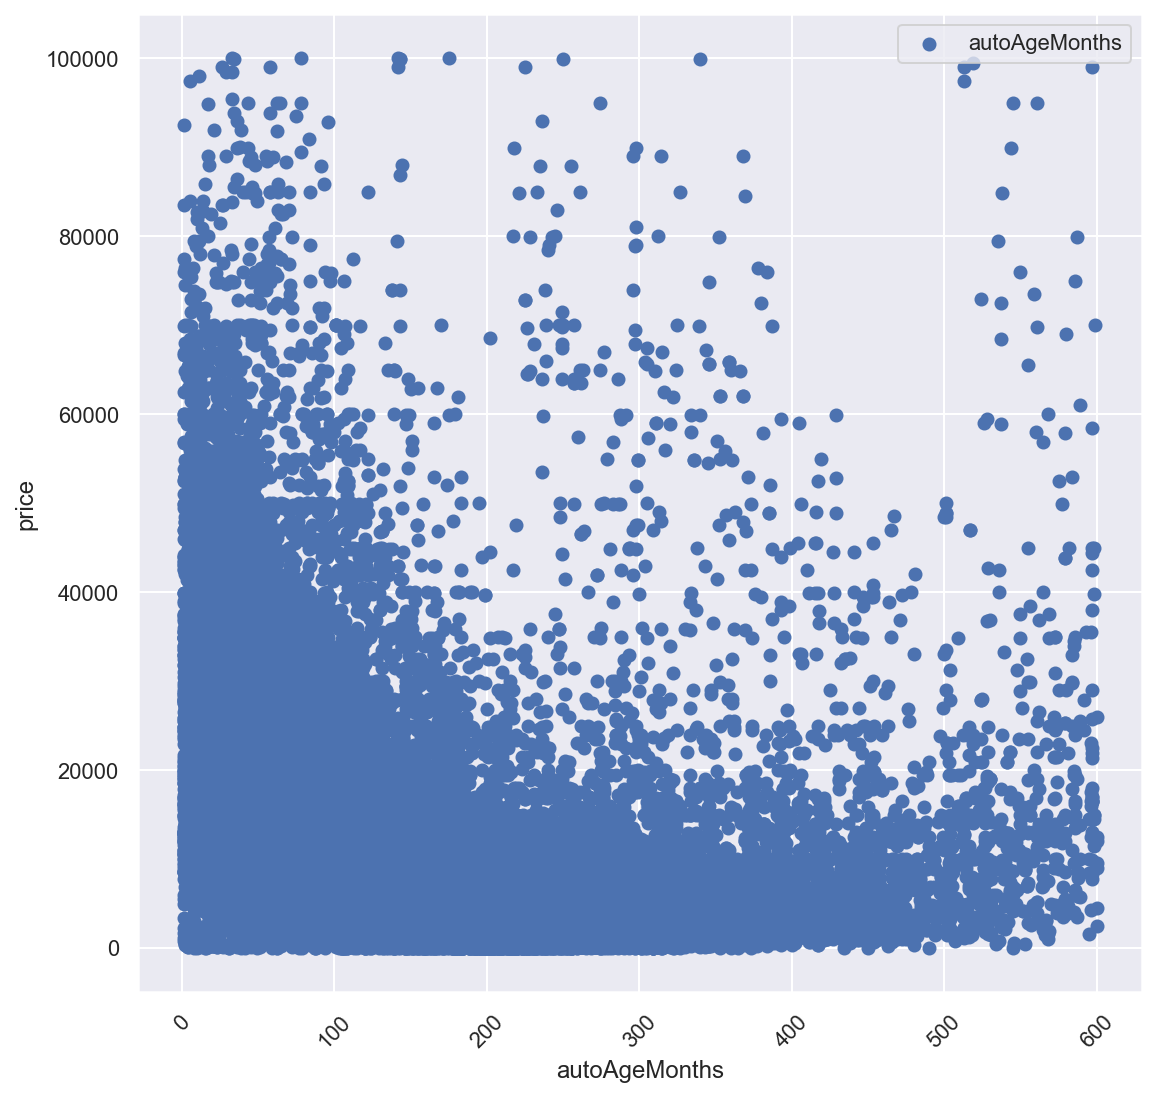

In [822]:
#вот так вот некрасиво смотрим распределения таргета относительно значения каждого признака
for feature in data.columns: 
    if feature != 'price':
        plt.figure(figsize=(9, 9))

        plt.scatter(x=data[feature], y=data['price'], label = feature)
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.ylabel('price')
        plt.legend()
        plt.show()


<AxesSubplot:xlabel='vehicleType', ylabel='price'>

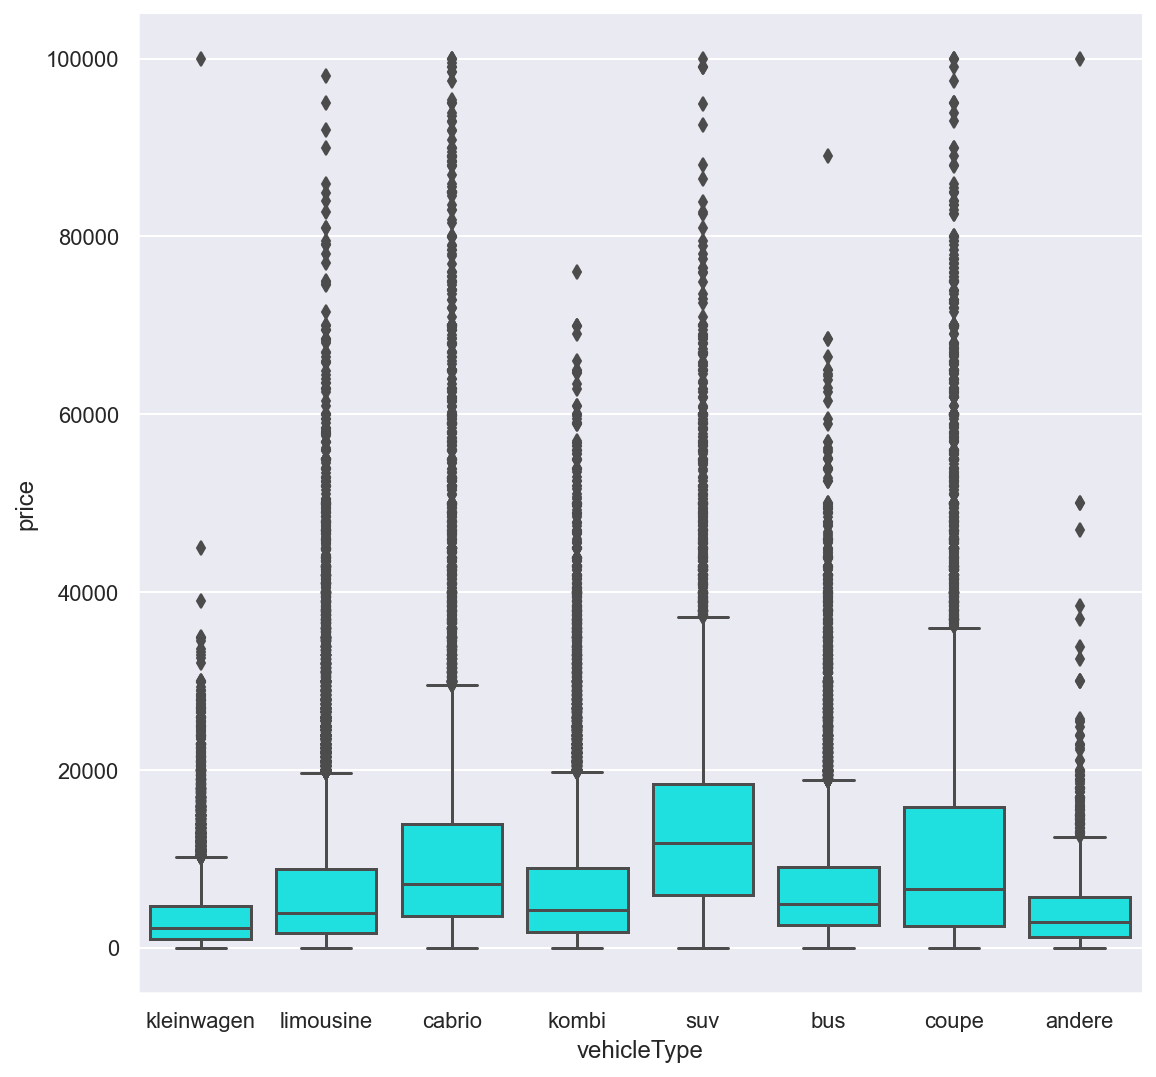

In [824]:
#посмотрела на признаки, над которыми сомневалась куда относить
plt.figure(figsize=(9, 9))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

sns.boxplot(x = data.vehicleType, y=data.price, data=data[['vehicleType', 'price']], color='cyan')


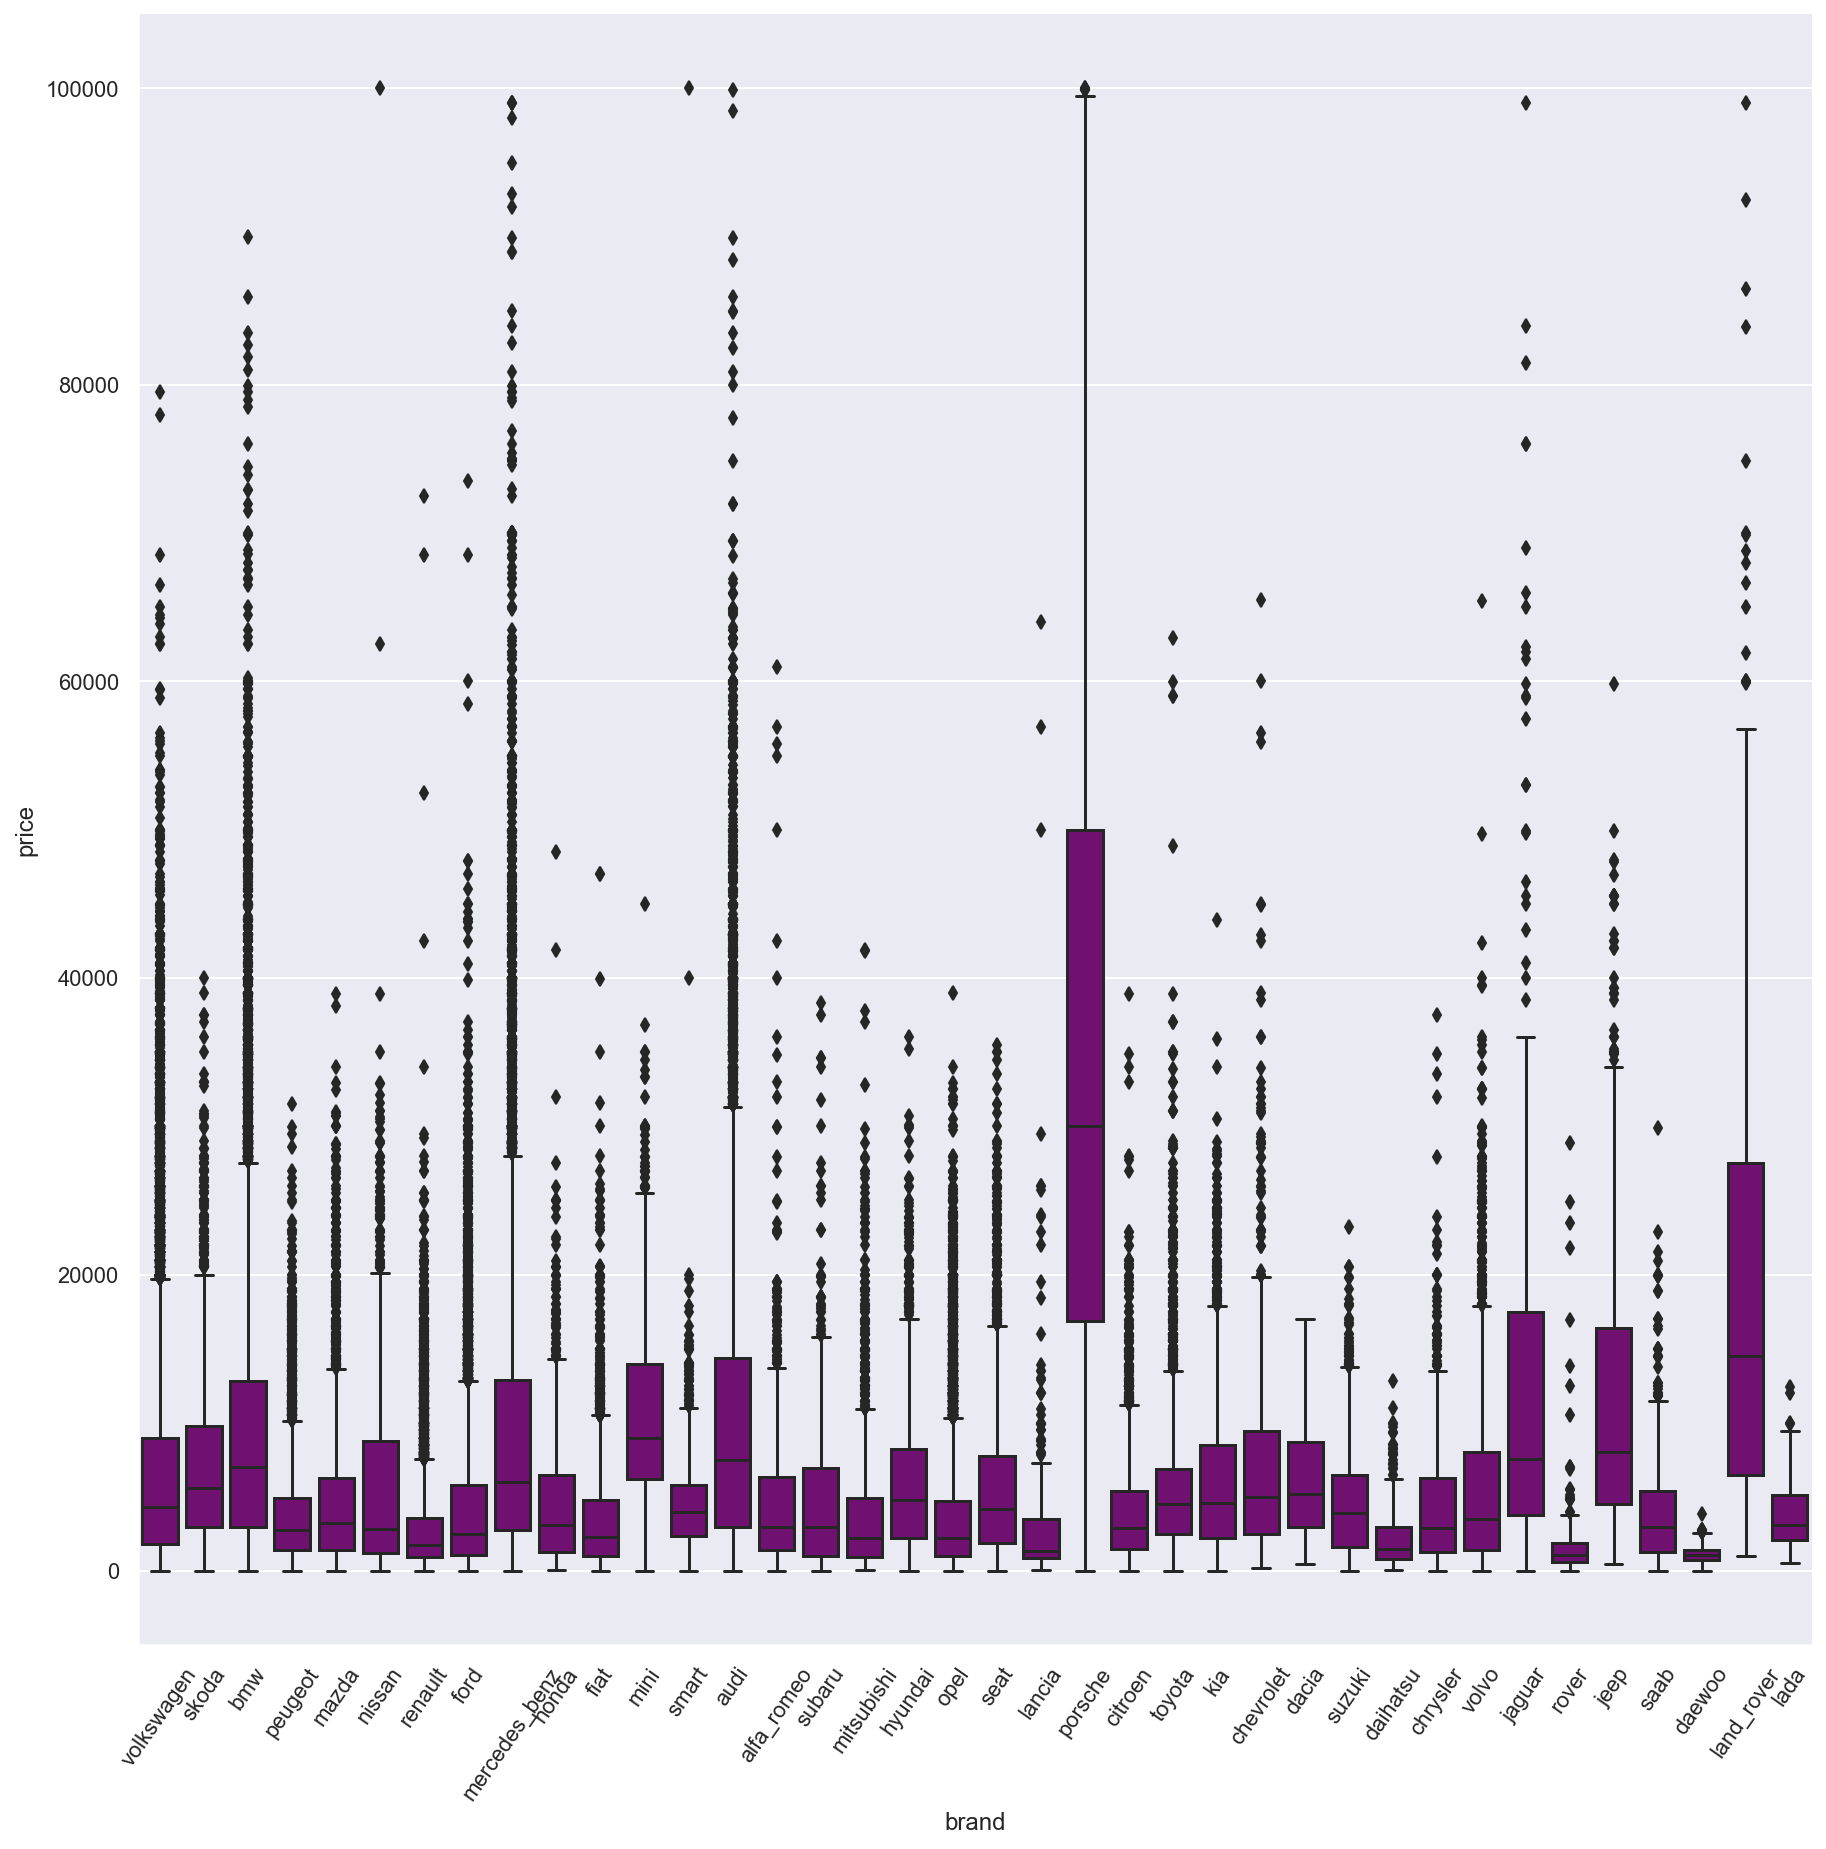

In [823]:
plt.figure(figsize=(15, 15))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#box plots
sns.boxplot(x = data.brand, y=data.price, data=data[['brand', 'price']], color='purple')
plt.xticks(rotation=55)
plt.show()

In [871]:
categorical = ['brand', 'vehicleType', 'fuelType'] #проанализировав признаки, решила распределить их так - можно использовать ohe
numeric = ['autoAgeMonths','powerPS', 'kilometer'] #можно стандартскейлер использовать
other = ['model', 'notRepairedDamage', 'gearbox'] 
#признак "модель" решила никак не обрабатывать, так как модель зависит от бренда, мы его уже обрабатываем, плюс моделей очень много


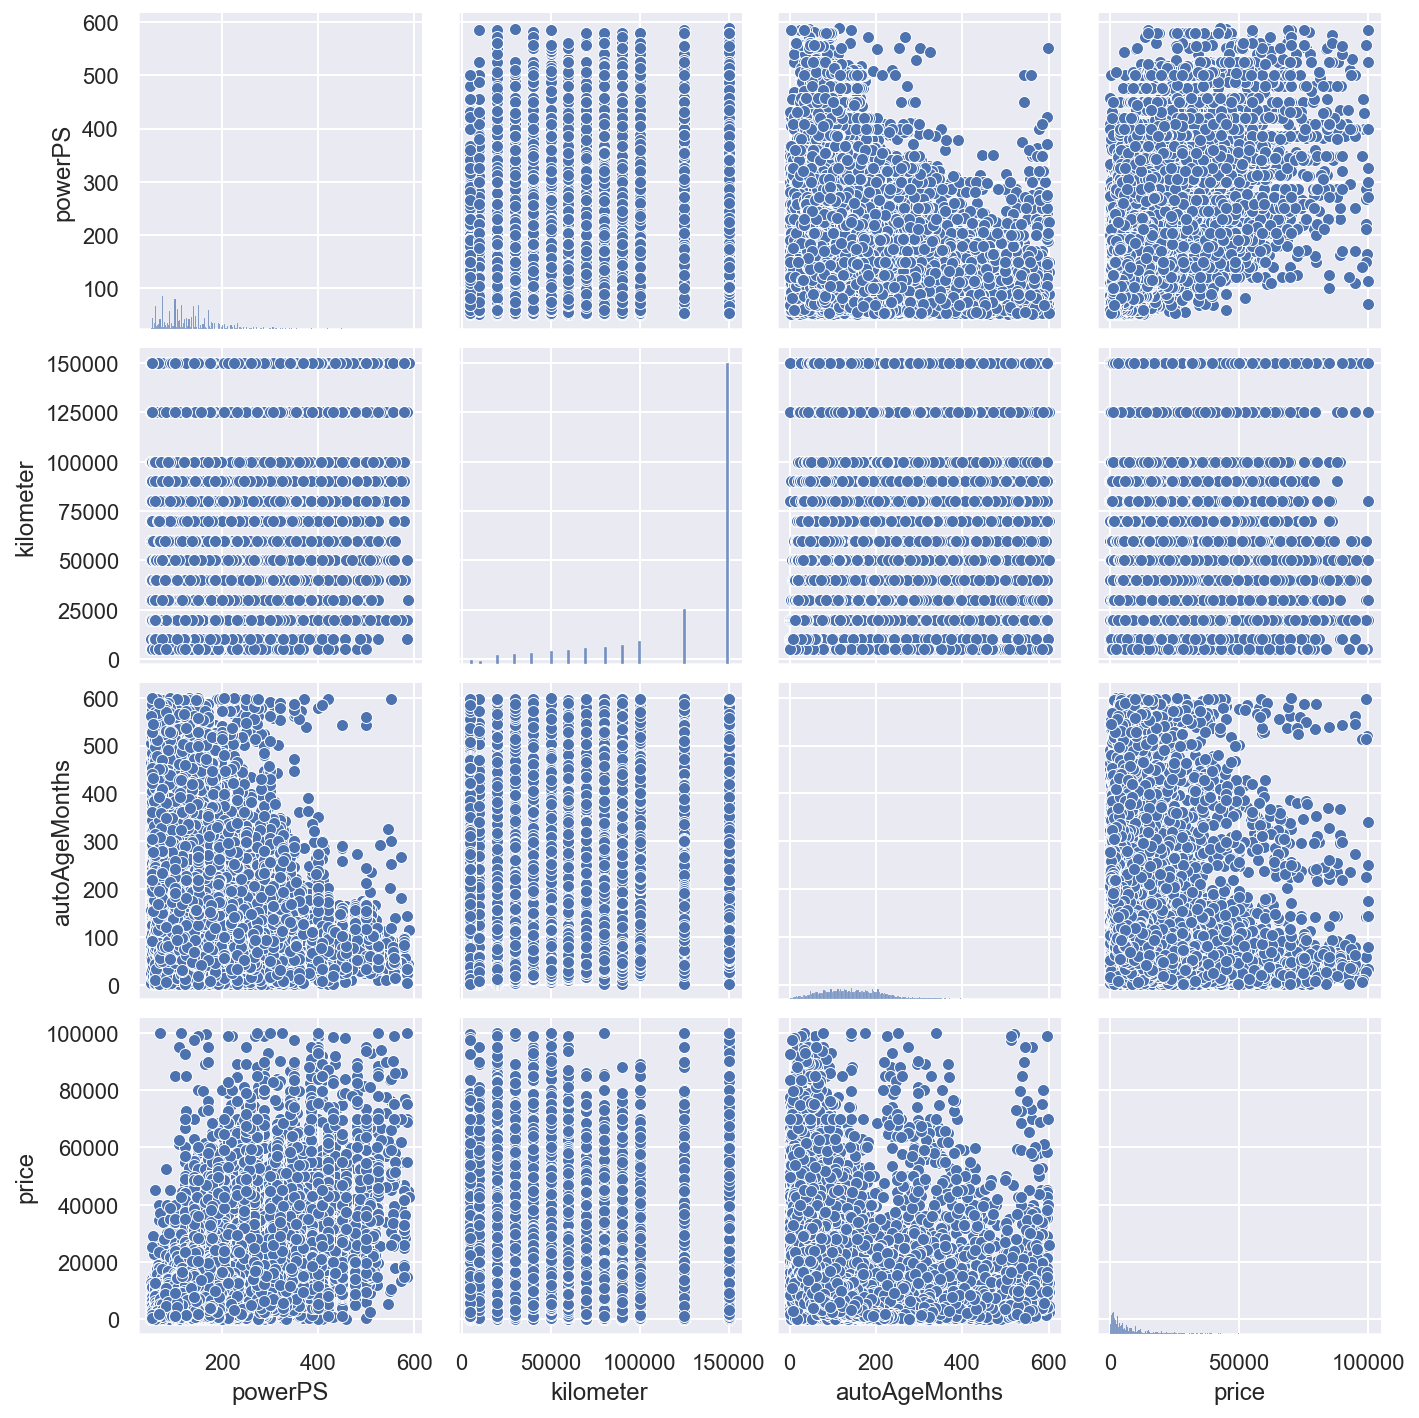

In [826]:
%config InlineBackend.figure_format = 'retina'

sns.pairplot(data) #только для числовых признаков

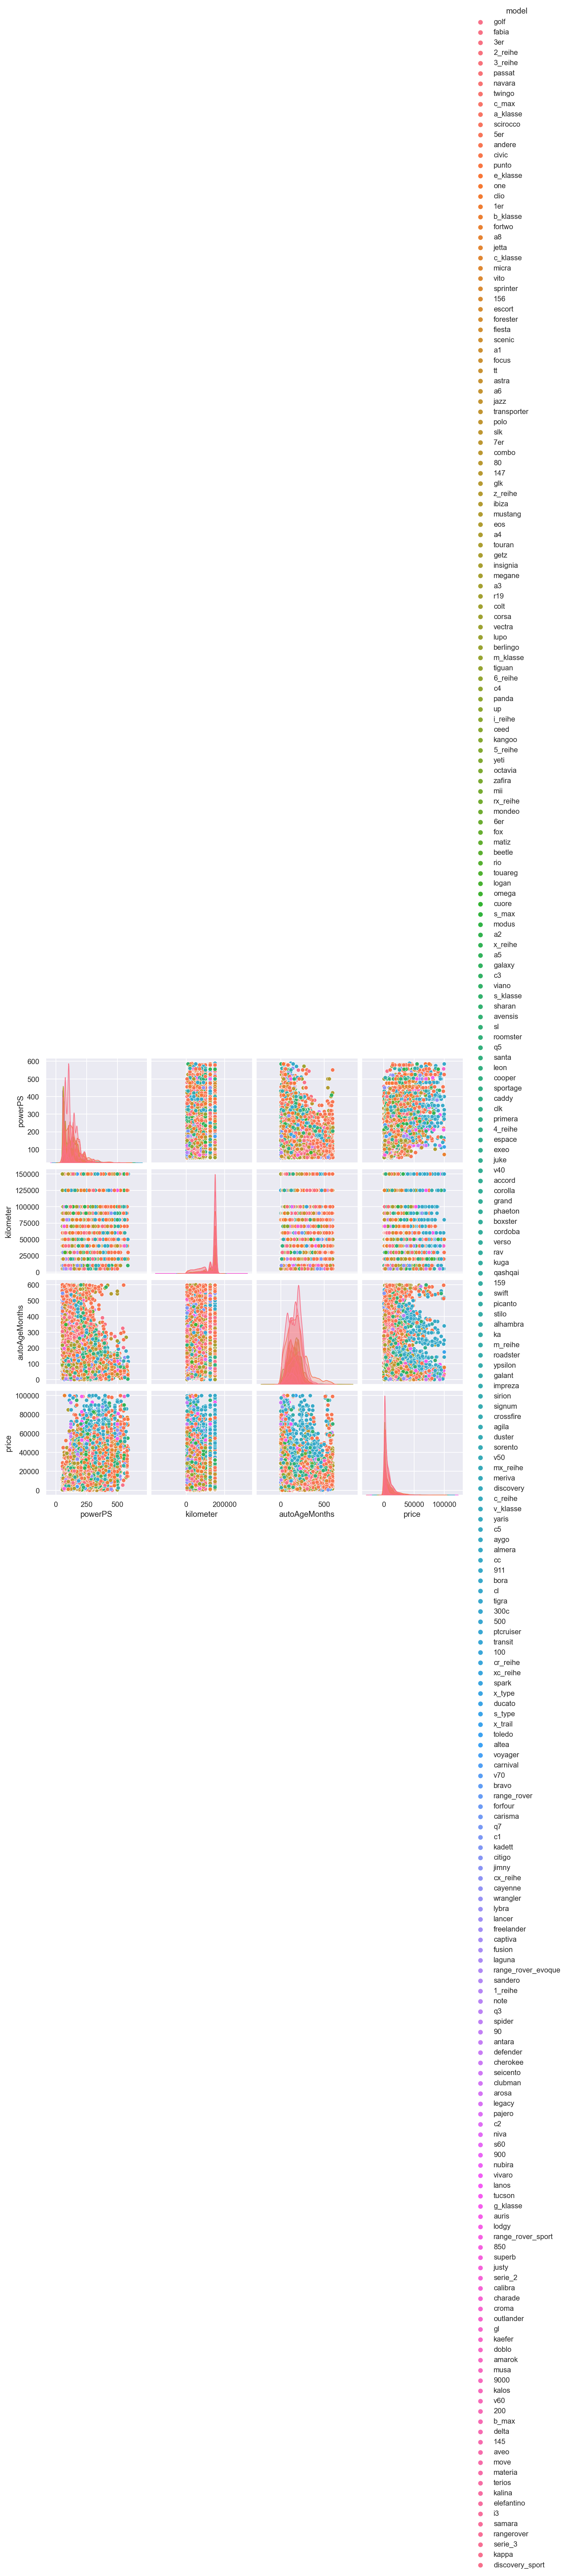

In [239]:

sns.pairplot(data, 
             hue='model');

In [872]:
data['bias'] = 1
other += ['bias']


In [873]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
x= data.drop(['price'], axis=1)
y = np.log(data['price'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)])

x = column_transformer.fit_transform(x)

In [874]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
X_val_arr = X_val.toarray()
X_test_arr = X_test.toarray()
X_train_arr = X_train.toarray()

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [875]:
from __future__ import annotations
from typing import List

class LinearRegression:

    learning_rate = None
    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
 
        self.descent: BaseDescent = get_descent(descent_config)
        self.iteration_count: int = 1
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []
        self.w_list: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        self.loss_history.append(self.calc_loss(x, y))
        for iteration in range(self.max_iter):
            y_pred = self.predict(x) 
            residual = y_pred - y 
            gradient = (2 / x.shape[0]) * (x.T @ residual)
            learning_rate =self.descent.lr()
            self.descent.w= self.descent.w - learning_rate * gradient
            self.w_list.append(self.descent.w)
            self.loss_history.append(self.calc_loss(x, y))
            self.iteration_count +=1

            if iteration > 0:
                if ((np.linalg.norm((self.w_list[-1] - self.w_list[-2]))**2) < self.tolerance) or (np.isnan(self.w_list[-1]).any()):              
                    break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:

        return self.descent.calc_loss(x, y)
    def plot_loss_history(self):
        x_values =self.iteration_count+1
        y_values = self.loss_history

        plt.plot(x_values, y_values)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss on Training Set')
        plt.show()

In [1012]:
from sklearn.metrics import r2_score
# ищем лямбды
lambdas = np.logspace(-3, 2, 20)
best_lambda = {}
dimension = X_train_arr.shape[1]
descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}
for descent_name in (['full', 'stochastic', 'momentum', 'adam']):
    best_loss = float('inf')
    best_lambda[descent_name] = None
    for learning_rate_value in lambdas:
        descent_config['descent_name'] = descent_name
        descent = get_descent(descent_config)

        LinearRegression.learning_rate = learning_rate_value

        model = LinearRegression(descent_config)
        model.fit(X_val_arr, y_val)
        loss = model.calc_loss(X_val_arr, y_val)
        
        if loss < best_loss:
            best_loss = loss
            best_lambda[descent_name] = learning_rate_value

    print(f"Descent name: {descent_name}, Loss: {loss}")
    
    print(f"Best lambda for {descent_name}: {best_lambda[descent_name]}")


Descent name: full, Loss: 6.0224950836781135
Best lambda for full: 0.02069138081114789


TypeError: __init__() takes from 2 to 3 positional arguments but 4 were given

In [881]:
best_iterations = {}
best_r2_test = {}
best_r2_train = {}
lc_test_d={}
lc_train_d={}
descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}
for descent_name in (['full', 'stochastic', 'momentum', 'adam']):
    best_iterations[descent_name] = 0
    best_r2_test[descent_name] = -float('inf')
    best_r2_train[descent_name] = -float('inf')
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)
    LinearRegression.learning_rate = best_lambda[descent_name]
    model = LinearRegression(descent_config)
    model.fit(X_train_arr, y_train)
    train_predictions = model.predict(X_train_arr)
    train_r2 = r2_score(y_train, train_predictions)
        
    test_predictions = model.predict(X_test_arr)
    test_r2 = r2_score(y_test, test_predictions)
    iterations = model.iteration_count
    best_iterations[descent_name] = iterations
    lc_train = model.calc_loss(X_train_arr, y_train)
    lc_test = model.calc_loss(X_test_arr, y_test)
    lc_test_d[descent_name] = lc_test
    lc_train_d[descent_name] = lc_train
    best_r2_test[descent_name] = test_r2
    best_r2_train[descent_name] = train_r2
print(f"R2-score на трейне:{best_r2_train}") #не поняла, почему он отрицательный
print(f"R2-score на тесте: {best_r2_test}")
print(f" mse-score на трейне:{lc_train_d}")
print(f" mse-score на тесте:{lc_test_d}")
       

R2-score на трейне:{'full': -35.404014667740704, 'stochastic': -33.72353188969724, 'momentum': -37.85621800345365, 'adam': -35.81970339701966}
R2-score на тесте: {'full': -36.71441589471812, 'stochastic': -34.99354311820188, 'momentum': -39.17489951409155, 'adam': -37.109432719402385}
 mse-score на трейне:{'full': 49.02042573900964, 'stochastic': 46.75754396680327, 'momentum': 52.32248054292081, 'adam': 49.580178246257674}
 mse-score на тесте:{'full': 49.18492322356426, 'stochastic': 46.94066215302951, 'momentum': 52.39374125880972, 'adam': 49.70008093536201}


### Задание 5.2. Сравнение методов (1 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

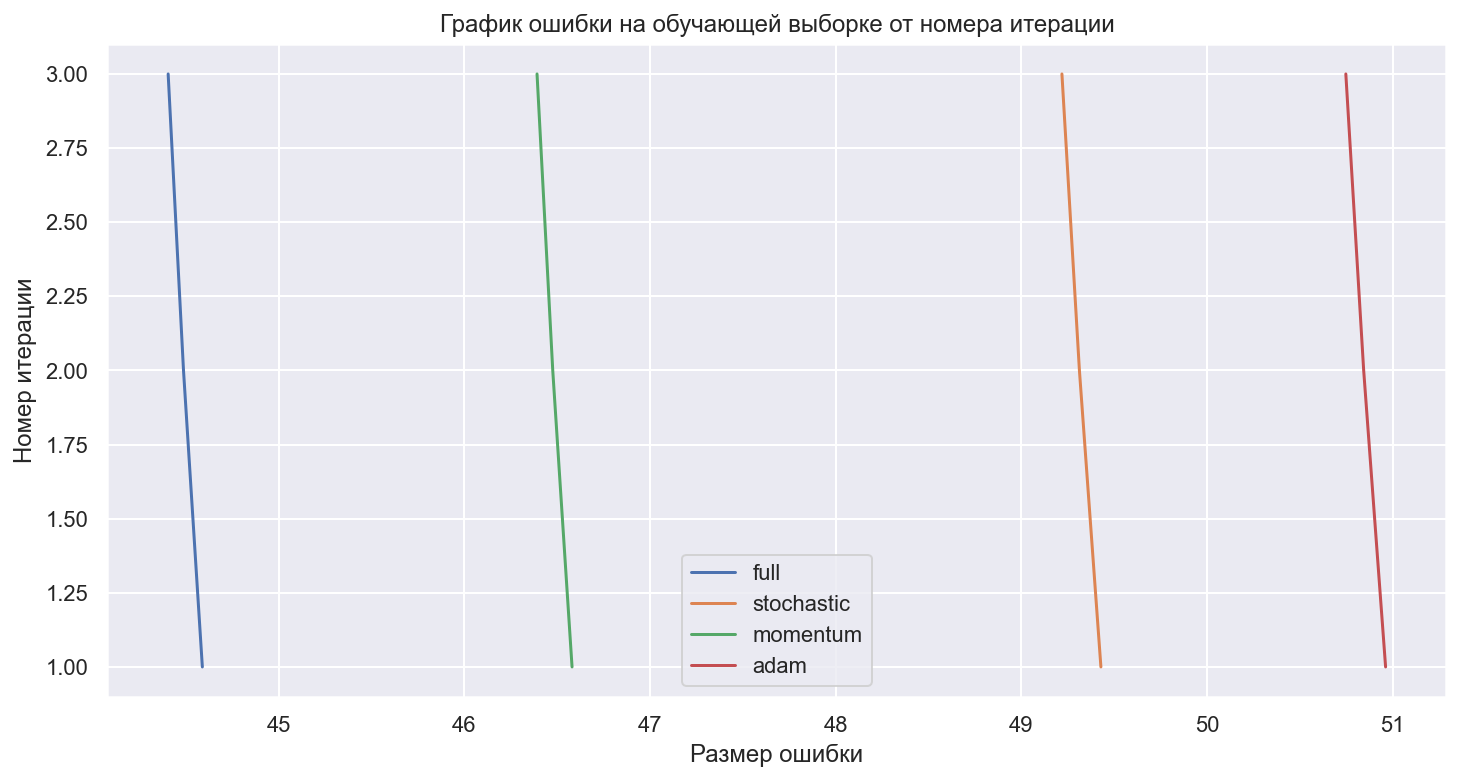

In [882]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

methods = ['full', 'stochastic', 'momentum', 'adam']
for descent_name in methods:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)
    LinearRegression.learning_rate = best_lambda[descent_name]
    model = LinearRegression(descent_config)
    model.fit(X_train_arr, y_train)
    plt.plot(model.loss_history, np.arange(1,model.iteration_count+1))
plt.legend(methods)
plt.xlabel('Размер ошибки')
plt.ylabel("Номер итерации")
plt.title('График ошибки на обучающей выборке от номера итерации')
plt.show();
# Построение графика ошибки на обучающей выборке от номера итерации
#у меня проблемы с количеством итераций, которые я не знаю, как решить, поэтому график не очень говорящий
#но дежае здесь при увеличении количества итераций ошибка уменьшается во всех методах


## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска.

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [883]:
import time
descent_config_sgd = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    },
    'batch_size': "number"
}
batch_sizes = np.arange(5, 500, 10)
average_iterations = {}
average_times = []
for batch_size in batch_sizes:
    iterations = []
    times = []
    for _ in range(10):
        start_time = time.time()
        descent_config_sgd['descent_name'] = 'stochastic'
        descent_config_sgd['batch_size'] =batch_size
        
        model = LinearRegression(descent_config)
        model.fit(X_train_arr,y_train)
        end_time = time.time()
        times.append(end_time - start_time)
        iterations.append(_ )

    average_iterations[batch_size] =np.mean(iterations)
    average_times.append(np.mean(times))


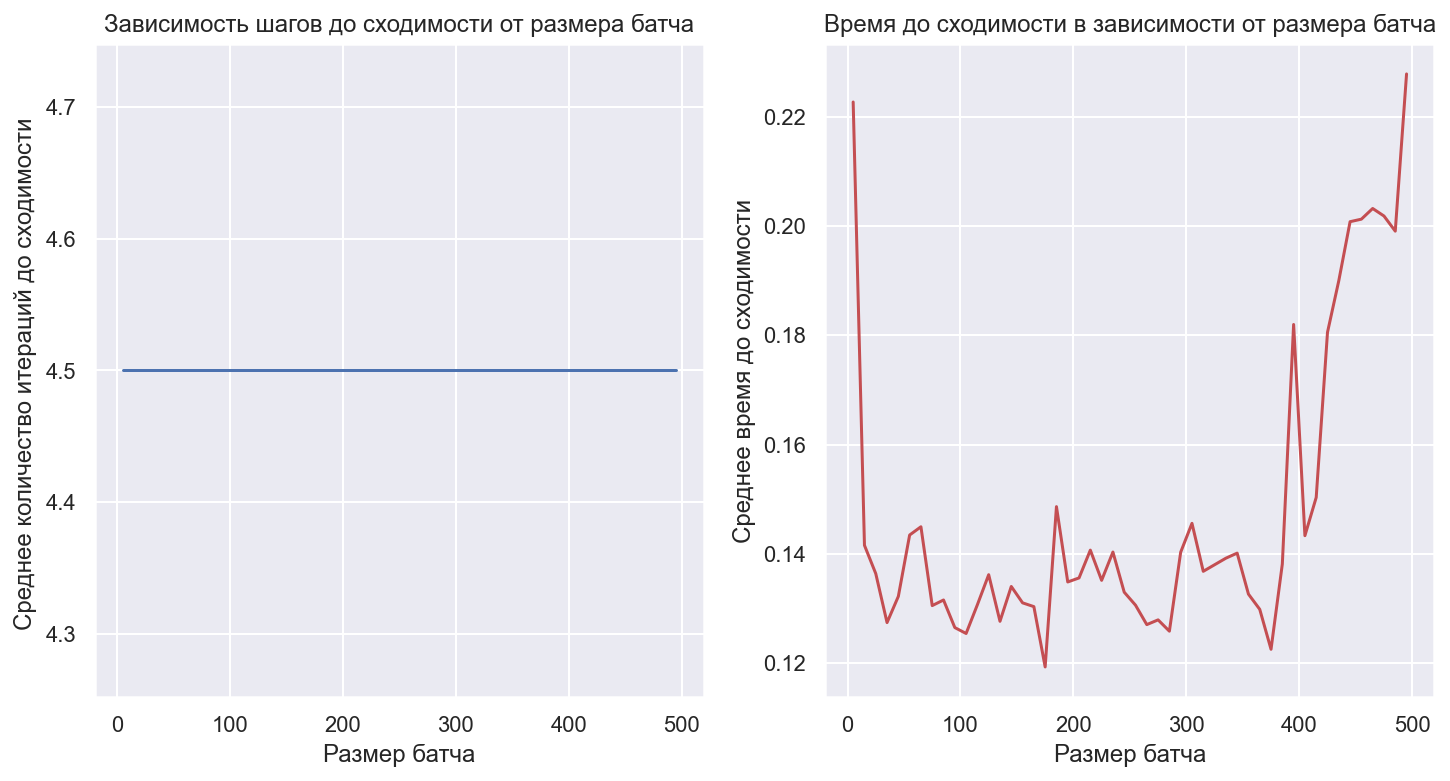

In [888]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes,(average_iterations.values()), "b-")
plt.xlabel("Размер батча")
plt.ylabel("Среднее количество итераций до сходимости ")
plt.title("Зависимость шагов до сходимости от размера батча")

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, average_times, "r-")
plt.xlabel("Размер батча")
plt.ylabel("Среднее время до сходимости")
plt.title("Время до сходимости в зависимости от размера батча")

plt.show()

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**:

In [889]:
#я не понимаю, что здесь не так, что только не придумывала в градиенте
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        l2_gradient = 2* self.w
        return super().calc_gradient(x, y) + l2_gradient * self.mu
# File "test_reg.py", line 10, in <module> - ошибка в контесте
#     from submission import AdamReg as class_tested
# ImportError: cannot import name 'AdamReg' from 'submission' (/temp/executing/submission.py)
# make: *** [run] Error 1

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [ ]:
# YOUR CODE:

`### ваше решение тут ###`

## Задание 8. Альтернативная функция потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$

Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент:

$$ \frac{d}{d(\cosh(a(x) - y))} \log(\cosh(a(x) - y)) = \frac{1}{\cosh(a(x) - y)} $$
$$ \frac{d}{da(x)} \cosh(a(x) - y) = -\sinh(a(x) - y) $$
$$ \frac{d}{da(x)} L(a(x),y) = \frac{1}{\cosh(a(x) - y)} \cdot (-\sinh(a(x) - y)) = -\tanh(a(x) - y) $$


Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [1014]:
from enum import auto #все пошло по одному месту при последнем запуске кода и я не успеваю найти ошибку
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

class BaseDescent:
    def __init__(self, dimension: int, loss_function: LossFunction = LossFunction.LogCosh):
        self.loss_function: LossFunction = loss_function
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))
    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.dot(x, self.w)
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        pass
    def calc_loss(self,x: np.ndarray, y: np.ndarray) -> float:
        if self.loss_function is LossFunction.MSE:
            return np.dot((y - np.dot(x, self.w)).T, (y - np.dot(x, self.w))) / x.shape[0]
        elif self.loss_function is LossFunction.LogCosh:
            error = y - np.dot(x, self.w)
            loss = np.mean(np.log(np.cosh(error)))
            return loss         
        
class VanillaGradientDescent(BaseDescent):
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        learning_rate = self.lr()
        update = - learning_rate * gradient 
        self.w += update
        return update

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            y_pred = self.predict(x)
            residual = y_pred - y 
            gradient = (2 / x.shape[0]) * (x.T @ residual) 
            return gradient
        elif self.loss_function is LossFunction.LogCosh:
            y_pred = self.predict(x)
            residual = y_pred - y
            gradient = np.dot(x.T, np.tanh(residual)) / len(y)
            return gradient

In [1015]:
class StochasticDescent(VanillaGradientDescent):

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,  loss_function: LossFunction = LossFunction.LogCosh):
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch = np.random.randint(0, x.shape[0], self.batch_size)
        x_batch = x[batch]
        y_batch = y[batch]
        y_pred = self.predict(x_batch)
        residual = y_pred - y_batch
        if self.loss_function is LossFunction.MSE:
            gradient = (2 / self.batch_size) * np.dot(np.transpose(x_batch), residual)
            return gradient
        elif self.loss_function is LossFunction.LogCosh:
            gradient = -np.dot(np.tanh(residual), x) / x.shape[0]
            return gradient

In [1016]:
class MomentumDescent(VanillaGradientDescent):

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.LogCosh):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        learning_rate = self.lr()
        self.h = self.alpha * self.h + learning_rate * gradient
        update_momentum = - self.h
        self.w += update_momentum
        return update_momentum
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.LogCosh):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        learning_rate = self.lr()
        self.iteration += 1 
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (gradient**2)
        m_hat = self.m / (1 - self.beta_1 ** (self.iteration))
        v_hat = self.v / (1 - self.beta_2 ** (self.iteration))
        update_adam = - learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)
        self.w += update_adam
        return update_adam

       

In [1017]:
from __future__ import annotations
from typing import List

class LinearRegression:

    learning_rate = None
    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
 
        self.descent: BaseDescent = get_descent(descent_config)
        self.iteration_count: int = 1
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []
        self.w_list: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        self.loss_history.append(self.calc_loss(x, y))
        for iteration in range(self.max_iter):
            y_pred = self.predict(x) 
            residual = y_pred - y 
            gradient = (2 / x.shape[0]) * (x.T @ residual)
            learning_rate =self.descent.lr()
            self.descent.w= self.descent.w - learning_rate * gradient
            self.w_list.append(self.descent.w)
            self.loss_history.append(self.calc_loss(x, y))
            self.iteration_count +=1

            if iteration > 0:
                if ((np.linalg.norm((self.w_list[-1] - self.w_list[-2]))**2) < self.tolerance) or (np.isnan(self.w_list[-1]).any()):              
                    break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:

        return self.descent.calc_loss(x, y)

In [1013]:
def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
         'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
         'momentum': MomentumDescent if not regularized else MomentumDescentReg,
         'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))


lambdas = np.logspace(-3, 2, 20)
best_lambda = {}
dimension = X_val_arr.shape[1]
descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}
for descent_name in (['full',  'momentum', 'adam', 'stochastic']):
    best_loss = float('inf')
    best_lambda[descent_name] = None
    for learning_rate_value in lambdas:
        descent_config['descent_name'] = descent_name
        descent = get_descent(descent_config)

        LinearRegression.learning_rate = learning_rate_value

        model = LinearRegression(descent_config)
        model.fit(X_val_arr, y_val)
        loss = model.calc_loss(X_val_arr, y_val)
        
        if loss < best_loss:
            best_loss = loss
            best_lambda[descent_name] = learning_rate_value

    print(f"Descent name: {descent_name}, Loss: {loss}")  #- на валидационной выборке
    

Descent name: full, Loss: 6.3025019911465225
Descent name: momentum, Loss: 50.499916608008114
Descent name: adam, Loss: 54.279988251472375


TypeError: __init__() takes from 2 to 3 positional arguments but 4 were given

### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

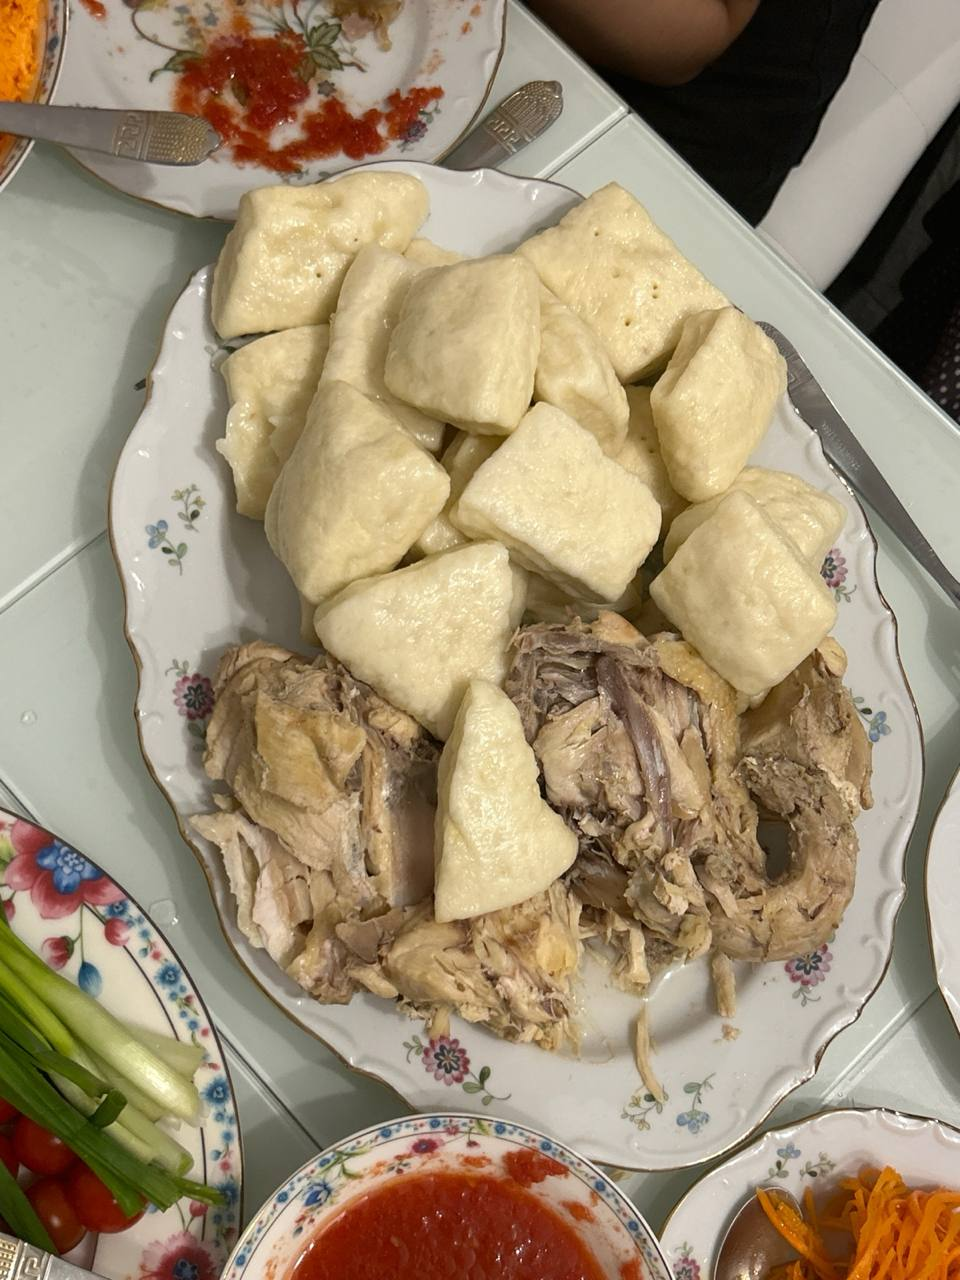

In [803]:
from IPython.display import Image
Image(r"C:\Users\murad\OneDrive\Изображения\хинкал.jpg", width=320, height=130)
#моя единственная возможность получить баллы - вашему вниманию представляется аварский хинкал (приготовлен не без помощи сестры)
#берем любое мясо, варим бульончик
# смешиваем муку, соль и соду и добавляем немного теплого кефира - все на глаз, как чувствуешь - мешаем тесто
# тесто режем на ромбики, варим в кипящем бульон 5 минут - не больше, так как они синеют)))
#можно сделать соус с чесноком/зеленью или томат - все готово

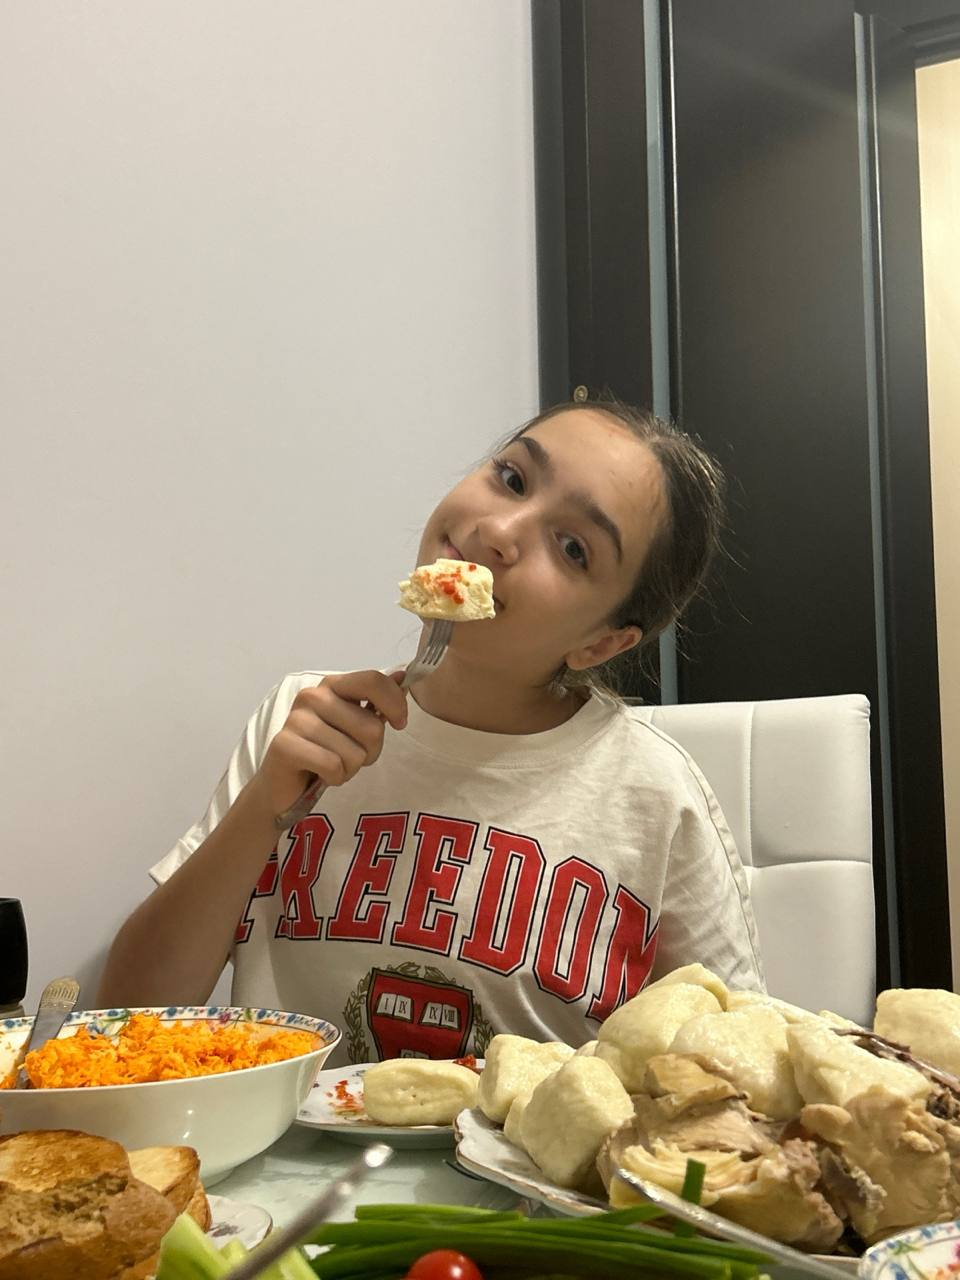

In [802]:
Image(r"C:\Users\murad\OneDrive\Изображения\амина.jpg", width=320, height=130)
#используем детей как бесплатных моделей

### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AdaMax` (вариация Adam основанная на $l_{\infty}$), `Nadam` (вариация Adam совмещенная с методом импульса Нестерова), `AMSGrad` (ещё одна вариация Adam).

In [995]:
from dataclasses import dataclass #огромная ячейка перекопированная из начала, ибо из-за прошлого пункта все ломается
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np

@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p
class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()
class BaseDescent:
    """
    A base class and templates for all functions
    """
    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass
    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass
    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        return np.dot((y - np.dot(x, self.w)).T, (y - np.dot(x, self.w))) / x.shape[0]

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return np.dot(x, self.w)
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()
        update = - learning_rate * gradient 
        self.w += update

        return update

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        y_pred = self.predict(x)
        residual = y_pred - y 
        gradient = (2 / x.shape[0]) * (x.T @ residual) 
        return gradient
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch = np.random.randint(0, x.shape[0], self.batch_size)
        x_batch = x[batch]
        y_batch = y[batch]

        y_pred = self.predict(x_batch)
        
        residual = y_pred - y_batch
        gradient = (2 /  self.batch_size) * np.dot(np.transpose(x_batch), residual)
        return gradient
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()

        self.h = self.alpha * self.h + learning_rate * gradient
        update_momentum = - self.h
        self.w += update_momentum
        return update_momentum
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        learning_rate = self.lr()
        self.iteration += 1 
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (gradient**2)
        m_hat = self.m / (1 - self.beta_1 ** (self.iteration))
        v_hat = self.v / (1 - self.beta_2 ** (self.iteration))
        update_adam = - learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)
        self.w += update_adam
        return update_adam
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        l2_gradient = 2* self.w
        return super().calc_gradient(x, y) + l2_gradient * self.mu
    
def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
        'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
        'momentum': MomentumDescent if not regularized else MomentumDescentReg,
        'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))
from __future__ import annotations

from typing import List

import numpy as np



class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []
        self.w_list: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        self.loss_history.append(self.calc_loss(x, y))

        for iteration in range(self.max_iter):
            y_pred = self.predict(x) 
            residual = y_pred - y 
            gradient = (2 / x.shape[0]) * (x.T @ residual)
            learning_rate =self.descent.lr()
            self.descent.w= self.descent.w - learning_rate * gradient
            self.w_list.append(self.descent.w)
            self.loss_history.append(self.calc_loss(x, y))

            if iteration > 0:
                if ((np.linalg.norm((self.w_list[-1] - self.w_list[-2]))**2) < self.tolerance) or (np.isnan(self.w_list[-1]).any()):              
                    break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)



In [1000]:
class AMSGrad(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        for i in range(1000):
            learning_rate_hat = self.lr()
            self.iteration += 1 
            self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
            self.v = self.beta_2 * self.v + (1 - self.beta_2) * (gradient**2)
            v_hat = np.maximum(v_hat, self.v)
            update_amsgrad = - learning_rate_hat * self.m / (np.sqrt(v_hat) + self.eps)
            self.w += update_amsgrad
            return update_amsgrad

In [1001]:
def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
         'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
         'momentum': MomentumDescent if not regularized else MomentumDescentReg,
         'adam': Adam if not regularized else AdamReg,
         'AMS': AMSGrad if not regularized else skip

    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))
descent_config['descent_name'] = 'AMS'
model = LinearRegression(descent_config)
model.fit(X_train_arr,y_train)
model.calc_loss(X_train_arr,y_train), model.calc_loss(X_test_arr,y_test) # ошибка на трейне и тесте до подбора лямбды

(54.32931804814752, 54.537700467827825)

In [1002]:
from sklearn.metrics import r2_score
#также подберем лучшую лямбду для этого метода по валидационной выборке
lambdas = np.logspace(-3, 2, 20)
best_loss = float('inf')
best_lambda = None
for learning_rate_value in lambdas:
        descent_config['descent_name'] = 'AMS'
        descent = get_descent(descent_config)
        LinearRegression.learning_rate = learning_rate_value
        model = LinearRegression(descent_config)
        model.fit(X_val_arr, y_val)
        loss = model.calc_loss(X_val_arr, y_val)
        if loss < best_loss:
            best_loss = loss
            best_lambda = learning_rate_value

print(f"Descent name AMSGrad Loss: {best_loss}")
print(f"Best lambda for AMSGrad: {best_lambda}")
    

Descent name AMSGrad Loss: 45.171785512905466
Best lambda for AMSGrad: 2.636650898730358


In [1003]:
LinearRegression.learning_rate = best_lambda
model = LinearRegression(descent_config)
model.fit(X_train_arr, y_train)
model.calc_loss(X_test_arr, y_test)
#в целом ошибка такая же, как была, особо улучшений не заметила

51.09668876255071

### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?